**README**

Below shows the evolution of the StableDiffusion Model

The First Two iterations of the stable diffusion model uses a two pass system

The 3rd and Final Iteration of the stable diffusion model uses a three pass system to futher refine the style.

The final iteration of the model is what we ended up settling on.


In Order to run any of the models, you must have a content image and you can set the path to that image with the CONTENT_PATH variable.

-If you want to change the style text prompt, simply change the string content in STYLE_PROMPT.

-If you want to have the negative Prompt, simply change the string content in NEGATIVE_PROMPT.

**Method**: Two-pass image-to-image style transfer

**Model Used**: Stable Diffusion XL (stabilityai/stable-diffusion-xl-base-1.0)

**Model Type**: Latent Diffusion Model

**Model Input**: Image + Text Prompt

**Model Output**: Stylized Image

**Generation Mode**: Image-to-image transformation with prompt conditioning

Starting two-pass SDXL on /content/IMG_1351.jpeg

Trying resolution 1024x1024 ...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, text_encoder_2, tokenizer, tokenizer_2, unet, image_encoder, feature_extractor, scheduler to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


  0%|          | 0/18 [00:00<?, ?it/s]

Saved -> sdxl_pass1_IMG_1351.png


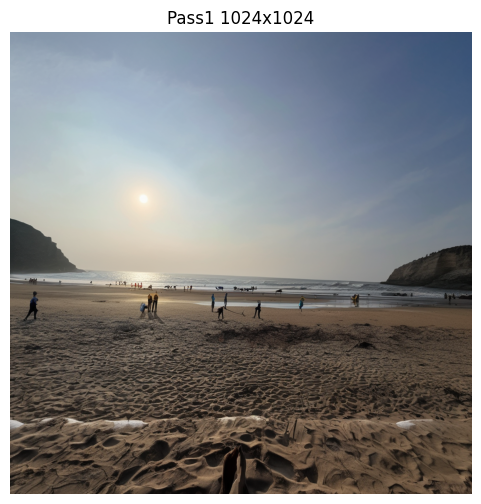

  0%|          | 0/36 [00:00<?, ?it/s]

Saved -> sdxl_pass2_IMG_1351.png


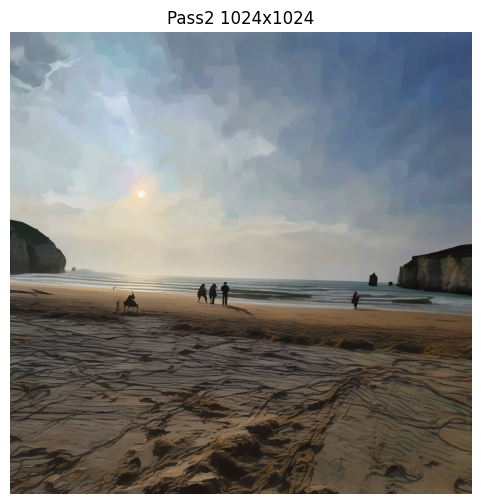

Done. Outputs: ('sdxl_pass1_IMG_1351.png', 'sdxl_pass2_IMG_1351.png')


In [ ]:
#@title First Model Iteration
#sdxl_two_pass_for_IMG_1351.py
import os
import torch
from PIL import Image
from diffusers import StableDiffusionXLImg2ImgPipeline
import matplotlib.pyplot as plt

CONTENT_PATH = "/content/IMG_1351.jpeg" #ADD CONTENT IMAGE HERE
OUT_PASS1 = "sdxl_pass1_IMG_1351.png"
OUT_PASS2 = "sdxl_pass2_IMG_1351.png"

MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"
STYLE_PROMPT = "van Gogh style painting, expressive brush strokes, vivid colors" #CHANGE STYLE TEXT PROMPT HERE
NEGATIVE_PROMPT = "blurry, distorted, mutated, low detail"
STRENGTH_PASS1 = 0.18
STRENGTH_PASS2 = 0.6
NUM_STEPS_PASS1 = 100
NUM_STEPS_PASS2 = 60
GUIDANCE_SCALE = 12
SEED = 42


RESOLUTIONS = [1024, 768, 640, 512] #preferred resolutions to try descending to avoid out-of-Memory error


def display_image(img: Image.Image, title: str = None): #Helper Functions
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def load_and_resize(path: str, size: int): #Helper Functions
    img = Image.open(path).convert("RGB")
    #keep square for SDXL img2img simplicity
    img = img.resize((size, size), Image.LANCZOS)
    return img

def save(img, p): #Helper Functions
    os.makedirs(os.path.dirname(p) or ".", exist_ok=True)
    img.save(p)
    print("Saved ->", p)




def make_pipe(dtype=torch.float16): #Pipeline Setip (lazy load)
    pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
        MODEL_ID, torch_dtype=dtype,)
    #VRAM optimizations
    try:
        pipe.enable_attention_slicing()
        pipe.enable_vae_slicing()
    except Exception:
        pass
    try:
        pipe.enable_model_cpu_offload()
    except Exception:
        pass
    return pipe




#TWO-PASS RUN (with OOM fallback)
def run_two_pass_with_fallback(content_path): #TWO-PASS RUN (with OOM fallback)
    last_err = None
    for R in RESOLUTIONS:
        print(f"\nTrying resolution {R}x{R} ...")
        try:
            content = load_and_resize(content_path, R)
        except Exception as e:
            print("Failed to load image:", e)
            return

        #create / move pipeline
        try:
            pipe = make_pipe()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            pipe.to(device)
        except RuntimeError as e:
            last_err = e
            print("Pipeline load OOM or error:", type(e).__name__, e)

            try: #try smaller resolution next iteration and free cuda memory
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            continue

        #generator
        gen = torch.Generator(device=pipe.device).manual_seed(SEED) if torch.cuda.is_available() else torch.Generator().manual_seed(SEED)

        try:
            #PASS 1
            out1 = pipe(
                prompt=STYLE_PROMPT,
                negative_prompt=NEGATIVE_PROMPT,
                image=content,
                strength=STRENGTH_PASS1,
                num_inference_steps=NUM_STEPS_PASS1,
                guidance_scale=GUIDANCE_SCALE,
                generator=gen,
            ).images[0]
            save(out1, OUT_PASS1)
            display_image(out1, f"Pass1 {R}x{R}")

            #PASS 2
            out2 = pipe(
                prompt=STYLE_PROMPT,
                negative_prompt=NEGATIVE_PROMPT,
                image=out1,
                strength=STRENGTH_PASS2,
                num_inference_steps=NUM_STEPS_PASS2,
                guidance_scale=GUIDANCE_SCALE,
                generator=gen,
            ).images[0]
            save(out2, OUT_PASS2)
            display_image(out2, f"Pass2 {R}x{R}")

            #success -> return paths
            try:
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            return OUT_PASS1, OUT_PASS2

        except RuntimeError as e:
            last_err = e
            print("Runtime error during generation (likely OOM):", type(e).__name__, e)
            try:
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            #try next smaller resolution
            continue


    print("Failed on all resolutions. Last error:", last_err)
    return None

#Main
if __name__ == "__main__":
    print("Starting two-pass SDXL on", CONTENT_PATH)
    out = run_two_pass_with_fallback(CONTENT_PATH)
    if out:
        print("Done. Outputs:", out)
    else:
        print("All retries failed. Consider running on CPU or using a smaller model (sdxl-turbo or 1.0 refiner).")

**Method**: Two-pass image-to-image style transfer

**Model Used**: Stable Diffusion XL (stabilityai/stable-diffusion-xl-base-1.0)

**Model Type**: Latent Diffusion Model

**Model Input**: Image + Text Prompt

**Model Output**: Stylized Image

**Generation Mode**: Image-to-image transformation with prompt conditioning

Starting two-pass SDXL on /content/contents.jpg

Trying resolution 1024x1024 ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.safetens(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, text_encoder_2, tokenizer, tokenizer_2, unet, image_encoder, feature_extractor, scheduler to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


  0%|          | 0/15 [00:00<?, ?it/s]

Saved -> sdxl_pass1_IMG_1351.png


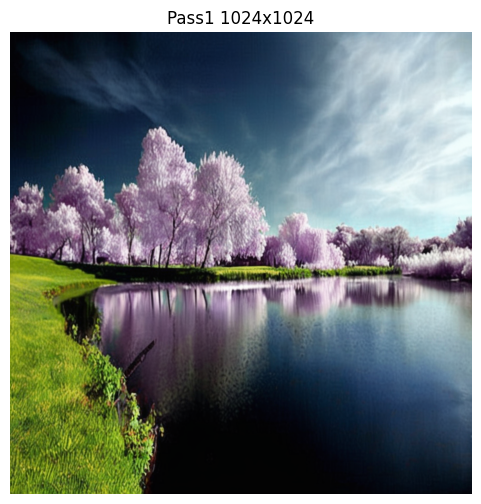

  0%|          | 0/62 [00:00<?, ?it/s]

Saved -> sdxl_pass2_IMG_1351.png


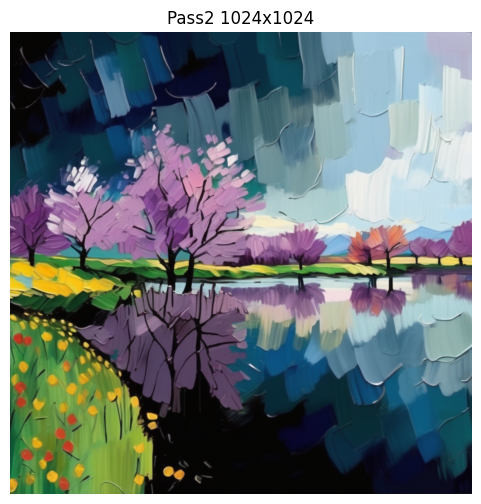

Done. Outputs: ('sdxl_pass1_IMG_1351.png', 'sdxl_pass2_IMG_1351.png')


In [ ]:
#@title 2nd Model Iteration
#sdxl_two_pass_for_IMG_1351.py
import os
import torch
from PIL import Image
from diffusers import StableDiffusionXLImg2ImgPipeline
import matplotlib.pyplot as plt

CONTENT_PATH = "/content/contents.jpg" #ADD CONTENT IMAGE HERE
OUT_PASS1 = "sdxl_pass1_IMG_1351.png"
OUT_PASS2 = "sdxl_pass2_IMG_1351.png"

MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"
STYLE_PROMPT = "van Gogh style painting, brush strokes, vivid colors" #CHANGE STYLE TEXT PROMPT HERE
NEGATIVE_PROMPT = "blurry, distorted, mutated, low detail"
STRENGTH_PASS1 = 0.1
STRENGTH_PASS2 = 0.7
NUM_STEPS_PASS1 = 150
NUM_STEPS_PASS2 = 90
GUIDANCE_SCALE = 12
SEED = 42


RESOLUTIONS = [1024, 768, 640, 512] #preferred resolutions to try descending. 768 is safe for ~15GB GPU.



def display_image(img: Image.Image, title: str = None): #Helper Function
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def load_and_resize(path: str, size: int): #Helper Function
    img = Image.open(path).convert("RGB")
    # keep square for SDXL img2img simplicity
    img = img.resize((size, size), Image.LANCZOS)
    return img

def save(img, p): #Helper Function
    os.makedirs(os.path.dirname(p) or ".", exist_ok=True)
    img.save(p)
    print("Saved ->", p)




def make_pipe(dtype=torch.float16): #Pipeline Setup (lazy load)
    pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
        MODEL_ID, torch_dtype=dtype,)
    #VRAM optimizations
    try:
        pipe.enable_attention_slicing()
        pipe.enable_vae_slicing()
    except Exception:
        pass
    try:
        pipe.enable_model_cpu_offload()
    except Exception:
        pass
    return pipe





def run_two_pass_with_fallback(content_path): #TWO-PASS RUN (with OOM fallback)
    last_err = None
    for R in RESOLUTIONS:
        print(f"\nTrying resolution {R}x{R} ...")
        try:
            content = load_and_resize(content_path, R)
        except Exception as e:
            print("Failed to load image:", e)
            return

        #create / move pipeline (create fresh each try to free memory)
        try:
            pipe = make_pipe()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            pipe.to(device)
        except RuntimeError as e:
            last_err = e
            print("Pipeline load OOM or error:", type(e).__name__, e)
            #try smaller resolution next iteration (and free cuda memory)
            try:
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            continue

        #generator
        gen = torch.Generator(device=pipe.device).manual_seed(SEED) if torch.cuda.is_available() else torch.Generator().manual_seed(SEED)

        try:
            #PASS 1
            out1 = pipe(
                prompt=STYLE_PROMPT,
                negative_prompt=NEGATIVE_PROMPT,
                image=content,
                strength=STRENGTH_PASS1,
                num_inference_steps=NUM_STEPS_PASS1,
                guidance_scale=GUIDANCE_SCALE,
                generator=gen,
            ).images[0]
            save(out1, OUT_PASS1)
            display_image(out1, f"Pass1 {R}x{R}")

            #PASS 2
            out2 = pipe(
                prompt=STYLE_PROMPT,
                negative_prompt=NEGATIVE_PROMPT,
                image=out1,
                strength=STRENGTH_PASS2,
                num_inference_steps=NUM_STEPS_PASS2,
                guidance_scale=GUIDANCE_SCALE,
                generator=gen,
            ).images[0]
            save(out2, OUT_PASS2)
            display_image(out2, f"Pass2 {R}x{R}")

            #success -> return paths
            try:
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            return OUT_PASS1, OUT_PASS2

        except RuntimeError as e:
            last_err = e
            print("Runtime error during generation (likely OOM):", type(e).__name__, e)
            try:
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            # try next smaller resolution
            continue


    print("Failed on all resolutions. Last error:", last_err)
    return None

#Main
if __name__ == "__main__":
    print("Starting two-pass SDXL on", CONTENT_PATH)
    out = run_two_pass_with_fallback(CONTENT_PATH)
    if out:
        print("Done. Outputs:", out)
    else:
        print("All retries failed. Consider running on CPU or using a smaller model (sdxl-turbo or 1.0 refiner).")

**Method**: Three-pass image-to-image style transfer

**Model Used**: Stable Diffusion XL (stabilityai/stable-diffusion-xl-base-1.0)

**Model Type**: Latent Diffusion Model

**Model Input**: Image + Text Prompt + Negative Prompt

**Model Output**: Stylized Image

**Generation Mode**: Image-to-image transformation with prompt conditioning

Starting two-pass SDXL on /content/contents.jpg

Trying resolution 1024x1024 ...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, text_encoder_2, tokenizer, tokenizer_2, unet, image_encoder, feature_extractor, scheduler to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


  0%|          | 0/13 [00:00<?, ?it/s]

Saved -> sdxl_pass1_IMG_1351.png


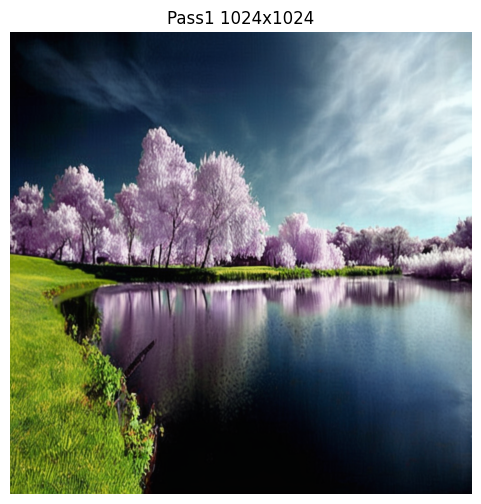

  0%|          | 0/62 [00:00<?, ?it/s]

Saved -> sdxl_pass2_IMG_1351.png


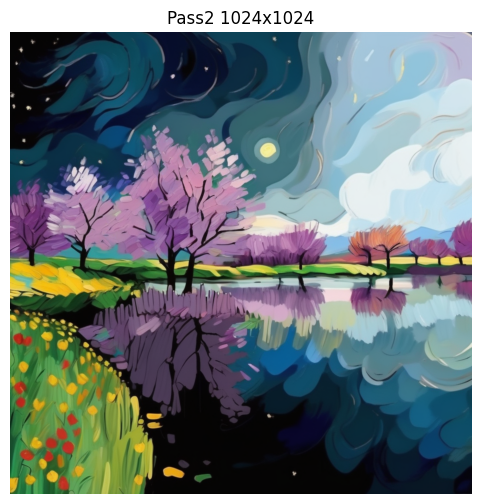

  0%|          | 0/40 [00:00<?, ?it/s]

Saved -> sdxl_pass3_IMG_1351.png


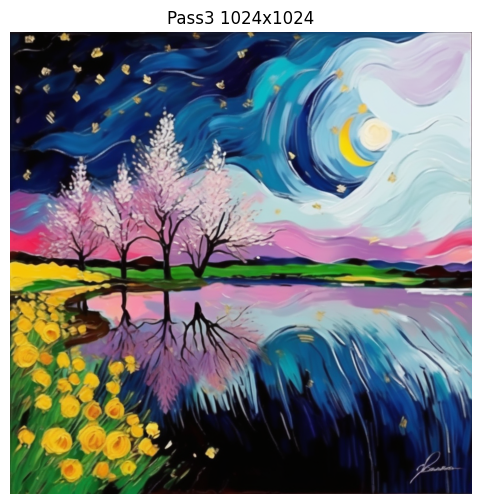

Done. Outputs: ('sdxl_pass1_IMG_1351.png', 'sdxl_pass2_IMG_1351.png')


In [ ]:
#@title 3rd Model Iteration
#sdxl_two_pass_for_IMG_1351.py
import os
import torch
from PIL import Image
from diffusers import StableDiffusionXLImg2ImgPipeline
import matplotlib.pyplot as plt


CONTENT_PATH = "/content/contents.jpg" #ADD CONTENT IMAGE HERE
OUT_PASS1 = "sdxl_pass1_IMG_1351.png"
OUT_PASS2 = "sdxl_pass2_IMG_1351.png"
OUT_PASS3 = "sdxl_pass3_IMG_1351.png"

MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"
STYLE_PROMPT = "van Gogh style painting, brush strokes, vivid colors" #CHANGE STYLE TEXT PROMPT HERE
NEGATIVE_PROMPT = "blurry, distorted, mutated, low detail" #CHANGE NEGATIVE PROMPT HERE
STRENGTH_PASS1 = 0.1
STRENGTH_PASS2 = 0.7
STRENGTH_PASS3 = 0.8
NUM_STEPS_PASS1 = 130
NUM_STEPS_PASS2 = 90
NUM_STEPS_PASS3 = 50
GUIDANCE_SCALE = 12
SEED = 42


RESOLUTIONS = [1024, 768, 640, 512] #preferred resolutions to try (descending). 768 is safe for ~15GB GPU.


def display_image(img: Image.Image, title: str = None): #Helper Function
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def load_and_resize(path: str, size: int): #Helper Function
    img = Image.open(path).convert("RGB")
    #keep square for SDXL img2img simplicity
    img = img.resize((size, size), Image.LANCZOS)
    return img

def save(img, p): #Helper Function
    os.makedirs(os.path.dirname(p) or ".", exist_ok=True)
    img.save(p)
    print("Saved ->", p)




def make_pipe(dtype=torch.float16):#PIPELINE SETUP (lazy load)
    pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
        MODEL_ID,
        torch_dtype=dtype,
    )
    #VRAM optimizations
    try:
        pipe.enable_attention_slicing()
        pipe.enable_vae_slicing()
    except Exception:
        pass
    try:
        pipe.enable_model_cpu_offload()
    except Exception:
        pass
    return pipe



def run_three_pass_with_fallback(content_path): #TWO-PASS RUN (with OOM fallback)
    last_err = None
    for R in RESOLUTIONS:
        print(f"\nTrying resolution {R}x{R} ...")
        try:
            content = load_and_resize(content_path, R)
        except Exception as e:
            print("Failed to load image:", e)
            return

        #create / move pipeline (create fresh each try to free memory)
        try:
            pipe = make_pipe()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            pipe.to(device)
        except RuntimeError as e:
            last_err = e
            print("Pipeline load OOM or error:", type(e).__name__, e)
            #try smaller resolution next iteration (and free cuda memory)
            try:
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            continue

        #generator
        gen = torch.Generator(device=pipe.device).manual_seed(SEED) if torch.cuda.is_available() else torch.Generator().manual_seed(SEED)

        try:
            #PASS 1
            out1 = pipe(
                prompt=STYLE_PROMPT,
                negative_prompt=NEGATIVE_PROMPT,
                image=content,
                strength=STRENGTH_PASS1,
                num_inference_steps=NUM_STEPS_PASS1,
                guidance_scale=GUIDANCE_SCALE,
                generator=gen,
            ).images[0]
            save(out1, OUT_PASS1)
            display_image(out1, f"Pass1 {R}x{R}")

            #PASS 2
            out2 = pipe(
                prompt=STYLE_PROMPT,
                negative_prompt=NEGATIVE_PROMPT,
                image=out1,
                strength=STRENGTH_PASS2,
                num_inference_steps=NUM_STEPS_PASS2,
                guidance_scale=GUIDANCE_SCALE,
                generator=gen,
            ).images[0]
            save(out2, OUT_PASS2)
            display_image(out2, f"Pass2 {R}x{R}")
            #PASS 3
            out3 = pipe(
                prompt=STYLE_PROMPT,
                negative_prompt=NEGATIVE_PROMPT,
                image=out1,
                strength=STRENGTH_PASS3,
                num_inference_steps=NUM_STEPS_PASS3,
                guidance_scale=GUIDANCE_SCALE,
                generator=gen,
            ).images[0]
            save(out3, OUT_PASS3)
            display_image(out3, f"Pass3 {R}x{R}")

            #success -> return paths
            try:
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            return OUT_PASS1, OUT_PASS2

        except RuntimeError as e:
            last_err = e
            print("Runtime error during generation (likely OOM):", type(e).__name__, e)
            try:
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            #try next smaller resolution
            continue


    print("Failed on all resolutions. Last error:", last_err)
    return None

#Main
if __name__ == "__main__":
    print("Starting two-pass SDXL on", CONTENT_PATH)
    out = run_two_pass_with_fallback(CONTENT_PATH)
    if out:
        print("Done. Outputs:", out)
    else:
        print("All retries failed. Consider running on CPU or using a smaller model (sdxl-turbo or 1.0 refiner).")

**Method**: Three-pass image-to-image style transfer

**Model Used**: Stable Diffusion XL (stabilityai/stable-diffusion-xl-base-1.0)

**Model Type**: Latent Diffusion Model

**Model Input**: Image + Text Prompt + Negative Prompt

**Model Output**: 3 interdiate image outputs after each pass.

**Generation Mode**: Image-to-image transformation with prompt conditioning

Starting two-pass SDXL on /content/cat.jpeg

Trying resolution 1024x1024 ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.safetens(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, text_encoder_2, tokenizer, tokenizer_2, unet, image_encoder, feature_extractor, scheduler to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


  0%|          | 0/13 [00:00<?, ?it/s]

Saved -> sdxl_pass1_IMG_1351.png


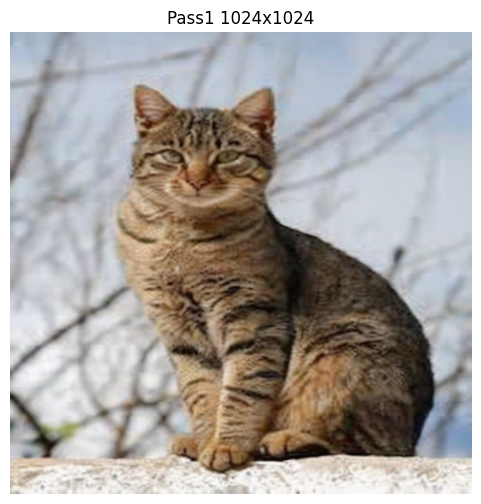

  0%|          | 0/62 [00:00<?, ?it/s]

Saved -> sdxl_pass2_IMG_1351.png


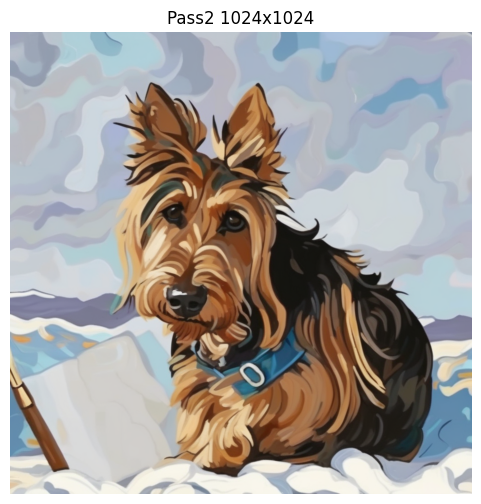

  0%|          | 0/40 [00:00<?, ?it/s]

Saved -> sdxl_pass3_IMG_1351.png


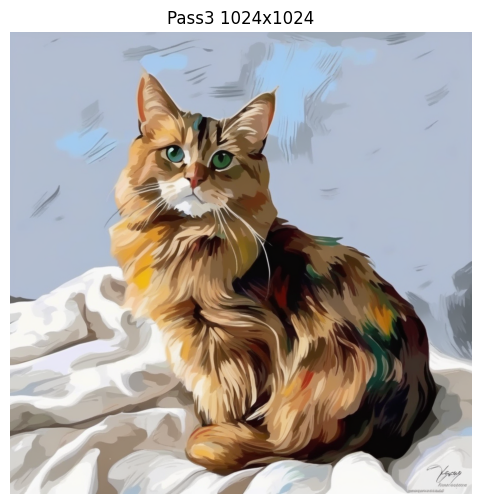

Done. Outputs: ('sdxl_pass1_IMG_1351.png', 'sdxl_pass2_IMG_1351.png')


In [ ]:
#@title Final Model Iteration
#sdxl_two_pass_for_IMG_1351.py
import os
import torch
from PIL import Image
from diffusers import StableDiffusionXLImg2ImgPipeline
import matplotlib.pyplot as plt


CONTENT_PATH = "/content/cat.jpeg" #ADD CONTENT IMAGE HERE
OUT_PASS1 = "sdxl_pass1_IMG_1351.png"
OUT_PASS2 = "sdxl_pass2_IMG_1351.png"
OUT_PASS3 = "sdxl_pass3_IMG_1351.png"

MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"
STYLE_PROMPT = "van Gogh style painting, brush strokes, vivid colors" #CHANGE STYLE TEXT PROMPT HERE
NEGATIVE_PROMPT = "blurry, distorted, mutated, low detail" #CHANGE NEGATIVE PROMPT HERE
STRENGTH_PASS1 = 0.1
STRENGTH_PASS2 = 0.7
STRENGTH_PASS3 = 0.8
NUM_STEPS_PASS1 = 130
NUM_STEPS_PASS2 = 90
NUM_STEPS_PASS3 = 50
GUIDANCE_SCALE = 12
SEED = 42

#preferred resolutions to try (descending). 768 is safe for ~15GB GPU.
RESOLUTIONS = [1024, 768, 640, 512]

#Helper Function
def display_image(img: Image.Image, title: str = None): #Helper Function
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def load_and_resize(path: str, size: int): #Helper Function
    img = Image.open(path).convert("RGB")
    #keep square for SDXL img2img simplicity
    img = img.resize((size, size), Image.LANCZOS)
    return img

def save(img, p): #Helper Function
    os.makedirs(os.path.dirname(p) or ".", exist_ok=True)
    img.save(p)
    print("Saved ->", p)



def make_pipe(dtype=torch.float16):#PIPELINE SETUP (lazy load)
    pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
        MODEL_ID,
        torch_dtype=dtype,
    )
    #VRAM optimizations
    try:
        pipe.enable_attention_slicing()
        pipe.enable_vae_slicing()
    except Exception:
        pass
    try:
        pipe.enable_model_cpu_offload()
    except Exception:
        pass
    return pipe



def run_three_pass_with_fallback(content_path): #TWO-PASS RUN (with OOM fallback)
    last_err = None
    for R in RESOLUTIONS:
        print(f"\nTrying resolution {R}x{R} ...")
        try:
            content = load_and_resize(content_path, R)
        except Exception as e:
            print("Failed to load image:", e)
            return

        #create / move pipeline (create fresh each try to free memory)
        try:
            pipe = make_pipe()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            pipe.to(device)
        except RuntimeError as e:
            last_err = e
            print("Pipeline load OOM or error:", type(e).__name__, e)
            #try smaller resolution next iteration (and free cuda memory)
            try:
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            continue

        #generator
        gen = torch.Generator(device=pipe.device).manual_seed(SEED) if torch.cuda.is_available() else torch.Generator().manual_seed(SEED)

        try:
            #PASS 1
            out1 = pipe(
                prompt=STYLE_PROMPT,
                negative_prompt=NEGATIVE_PROMPT,
                image=content,
                strength=STRENGTH_PASS1,
                num_inference_steps=NUM_STEPS_PASS1,
                guidance_scale=GUIDANCE_SCALE,
                generator=gen,
            ).images[0]
            save(out1, OUT_PASS1)
            display_image(out1, f"Pass1 {R}x{R}")

            #PASS 2
            out2 = pipe(
                prompt=STYLE_PROMPT,
                negative_prompt=NEGATIVE_PROMPT,
                image=out1,
                strength=STRENGTH_PASS2,
                num_inference_steps=NUM_STEPS_PASS2,
                guidance_scale=GUIDANCE_SCALE,
                generator=gen,
            ).images[0]
            save(out2, OUT_PASS2)
            display_image(out2, f"Pass2 {R}x{R}")

            #Pass 3
            out3 = pipe(
                prompt=STYLE_PROMPT,
                negative_prompt=NEGATIVE_PROMPT,
                image=out2,
                strength=STRENGTH_PASS3,
                num_inference_steps=NUM_STEPS_PASS3,
                guidance_scale=GUIDANCE_SCALE,
                generator=gen,
            ).images[0]
            save(out3, OUT_PASS3)
            display_image(out3, f"Pass3 {R}x{R}")

            #success -> return paths
            try:
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            return OUT_PASS1, OUT_PASS2

        except RuntimeError as e:
            last_err = e
            print("Runtime error during generation (likely OOM):", type(e).__name__, e)
            try:
                del pipe
                torch.cuda.empty_cache()
            except Exception:
                pass
            #try next smaller resolution
            continue


    print("Failed on all resolutions. Last error:", last_err)
    return None

#Main
if __name__ == "__main__":
    print("Starting two-pass SDXL on", CONTENT_PATH)
    out = run_three_pass_with_fallback(CONTENT_PATH)
    if out:
        print("Done. Outputs:", out)
    else:
        print("All retries failed. Consider running on CPU or using a smaller model (sdxl-turbo or 1.0 refiner).")